<a href="https://colab.research.google.com/github/kp233358/Quantum--Computing/blob/main/Grovers_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import All the Tools

In [ ]:
# Kishen Patil
# Implementing Grover's Search Algorithm
# 21 April 2025


import logging
# Suppress all logging from stevedore (which is needed with QISKIT 2.0 for some reason...)
logging.getLogger("stevedore.extension").propagate = False
logging.getLogger("stevedore.extension").disabled = True

try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

try:

  !pip install qiskit-aer
  from qiskit_aer import QasmSimulator
  from qiskit_aer import Aer

  print('Qiskit Aer imported');
except ImportError:
  print('Install Qiskit-Aer')
  !pip install --quiet qiskit-aer


try:
  from qiskit_ibm_runtime import QiskitRuntimeService
  print('Qiskit-IBM-Runtime imported')

except ImportError:
  print('Install Qiskit-IBM-Runtime')
  !pip install --quiet qiskit-ibm-runtime
  !pip install --quiet qiskit_ibm_provider[visualization]


from IPython.display import display, Math, Image
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos
import math
import time

#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML

#Qisket imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city, plot_state_hinton
from qiskit.visualization import array_to_latex
from qiskit.visualization import *

from qiskit_aer import QasmSimulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, pauli_error

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

from qiskit.circuit.library import *
from qiskit.circuit.library import GroverOperator
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import Statevector, Operator



Qiskit Aer imported
Qiskit-IBM-Runtime imported


# Setup QPU

In [ ]:
##################### set up transpile ######################

# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

tok = '' # my unique token to access IBM Brisbane

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
  token = tok,
  channel = "ibm_quantum_platform", # `channel` distinguishes between different account types
  overwrite = True,
  set_as_default = True
)

service = QiskitRuntimeService()

backend = service.backend("ibm_brisbane"); # use Brisbane QPU

initLayout = [];
pass_manager = generate_preset_pass_manager(optimization_level = 0, backend = backend, seed_transpiler = 0, initial_layout = initLayout); # initialize the QPU


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-15 19:25:15,252: Default instance not set. Searching all available instances.
ERROR:stevedore.extension:Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.11/dist-packages/qiskit/providers/__init__.py)
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/usr/local/lib/python3.11/dist-packages/qiskit/providers/__init__.py)


# Create the Oracle and the Diffuser

In [40]:
QasmSim = QasmSimulator() # Setup simulator to simulate a quantum circuit

def ideal_sim(qc,numShots = 100): # an ideal simulation (no noise), ran 100 times
    job = QasmSim.run(qc, shots = numShots)
    result = job.result()
    count = result.get_counts() # count and record the number of output states produced by the quantum circuit
    return count

def create_oracle(n_qubits: int, solns): # pass in the number of qubtis and what the answer is
    '''
    Creates an oracle gate for Grover's algorithm that marks a specific solution state

    Args:
        n_qubits: Number of qubits in the circuit
        solution: Integer representing the marked solution state

    Returns:
        Oracle gate as a QuantumCircuit object
    '''

    '''
    The Oracle in Grovers search algorithm is what iterates through all the possible answers, but closes in on the one with the highest probability.
    The Oracle requires you to know the answer youre looking for (denoted |w>). It then takes |w> and inverts the sign of |w>. In other words, |w> becomes -|w>. This essentially flags the |w> state as the answer and singles out all the others.
    Grovers search is an algorithm akin to searching a database. You need to know what to look for when searching a database, and in this case it is a specific state |w>.
    Given n qubits, there are 2^n possible states to 'search' through with |w> being the state you are looking for.
    When the oracle operator finds |w>, it flips its sign from |w> to -|w> which is intended to mark the answer.

    '''

    N = 2**n_qubits; # number of possible states
    M = len(solns); # number of solutions

    #print(f"Max of {n_qubits} is {N - 1}\n") # Print info about the register size and solution
    #print(f"Number of solutions = {M}\n");

    matrix = np.identity(N, complex) # create a 2^N x 2^N identity matrix that can generally be complex

    for m in range(M):

      soln = solns[m];

      # Create oracle matrix - identity with negative entry at solution

      matrix[soln, soln] = -1 * matrix[soln, soln]; # invert only the entry of the solution

      # the matrix is diagonal - there are non-zero entries only along matrix[k][k] and zeros everywhere else.
      # The diagonal entries correspond to the projections of every state onto themselves thus the diagonal entries represent the probabilities of each unique state.

    # Convert matrix to quantum gate
    controls = QuantumRegister(n_qubits) # create a Quantum Register with n qubits
    circuit = QuantumCircuit(controls) # initialize a quantum circuit with the quantum register
    gate = Operator(matrix) # matrix as a gate operation
    circuit.unitary(gate, range(0, n_qubits)) # normalize the operation (ie make that gate unitary, it does not alter the probability of the state but it does change its overall state)

    # Create named oracle gate
    Oracle = circuit.to_gate() # turn the oracle circuit into a gate
    Oracle.name = 'Oracle' # name the gate

    return Oracle

def create_diffuser(n_qubits):

    qc = QuantumCircuit(n_qubits)

    for qubit in range(n_qubits): # put all the qubits in |+> state. In our practice, this will actually put all the entire state in |000 ... 0>.
    # The diffuser assumes that all the qubits are already in the X basis, since the first operation of the overall circuit is H-gates on all qubits.

        qc.h(qubit)

    for qubit in range(n_qubits): # flip all the qubit states from |000 ... 0> to |111 ... 1>
        qc.x(qubit)


    qc.append(MCPhaseGate(lam = pi , num_ctrl_qubits = n_qubits - 1), list(range(n_qubits))) # add a pi phase to flip the sign of the |111 ... 1> state

    # the essence of this (N - 1) controlled phase gate is that the sign of the state |phi> is flipped only if all of the qubits are in |1>. That is |111 ... 1> becomes -|111 ... 1>.
    # the MCPhase gate is in essence a multi-control Z gate. Z gates are what add / subtract phase from qubits.
    # Recall that the general form of a qubit state is c0*|0> + c1*exp(theta)*|1> where theta = relative phase between |0> and |1> and resides in the X / Y plane of the Bloch sphere.
    # This is the single gate operation that produces 2|s><s| - I operation. Everything around this is just to transform basis's.


    for qubit in range(n_qubits): # put all the qubits back into |0> state to become -|000 ... 0>
        qc.x(qubit)

    for qubit in range(n_qubits): # take all of the qubits out of the Z basis to produce \|s>
        qc.h(qubit)

    qc.name = "U$_s$ - Reflect about |s⟩" # name the quantum circuit

    return qc


def backend_real(qc, backend = None, shots = 1000, optimization_level = 3):

    if backend is None:

        from qiskit_ibm_runtime.fake_provider import FakeBrisbane

        service = QiskitRuntimeService(channel = 'ibm_quantum_platform');
        backend = FakeBrisbane(); # use Brisbane QPU
        backend.refresh(service)
        #backend = service.backend("ibm_brisbane")

    pm = generate_preset_pass_manager(optimization_level = optimization_level, backend = backend, seed_transpiler = 0)
    tqc = pm.run(qc)

    sampler = Sampler(backend)
    job = sampler.run([tqc],shots=shots)

    result = job.result()

    data_keys = list(result[0].data.keys())
    counts = result[0].data[data_keys[0]].get_counts()

    return counts


# Number of CNOT Gates v. Number of Qubits

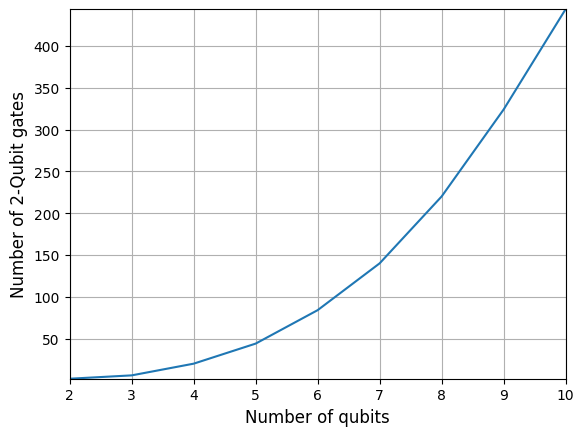

In [ ]:

n = np.arange(2,11) # number of qubits (2, 3, 4, ..., 10)

cxCount = []; # keep track of how many controlled not gates there are

for k in n: # run the same experiment for each number of qubits

  k = int(k); # make sure the qubit number is an integer value

  qc_MCPHASEGATE = QuantumCircuit(k) # create a k-qubit quantum circuit

  '''Multi-controlled-Z gate'''
  qc_MCPHASEGATE.append(MCPhaseGate(lam = pi , num_ctrl_qubits = k - 1), list(range(0, k))) # add a multi-qubit controlled phase gate. lam = amount of phase to apply to target qubit, num_ctrl_qubits = number of control qubits, add all the qubits to the circuit?

  decomposed_circ = qc_MCPHASEGATE.decompose().decompose()

  gateCounts = decomposed_circ.count_ops()['cx']; # count the number of Controlled - NOT gates needed to support a multi-qubit controlled phase circuit
  cxCount.append(gateCounts);

fs = 12;
plt.xlabel("Number of qubits", fontsize = fs);
plt.ylabel("Number of CNOT Gates", fontsize = fs);
plt.xlim(min(n), max(n));
plt.ylim(min(cxCount), max(cxCount))
plt.plot(n, cxCount);
plt.grid();
plt.show();

Complexity of the circuit grows exponentially with number of qubits

# Implementing the Oracle and Diffuser with QasmSimulator

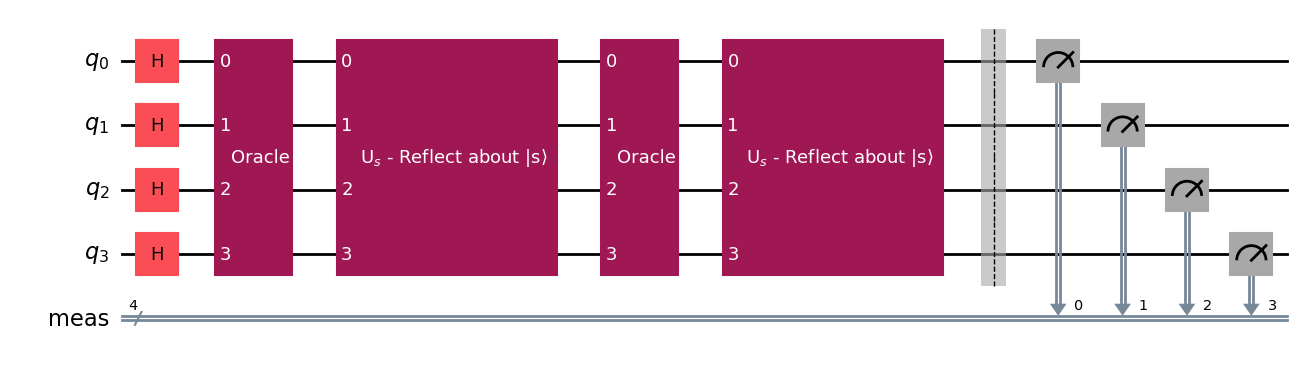

In [10]:

n = 4 # Number of qubits

SOLNS = [0, 15] # solutions we are looking for
numSolns = len(SOLNS); # number of solutions

N = 2**n # number of possible states

n_shots = 100 * N; # number of shots

t = int(floor(pi * sqrt(N / numSolns) / 4)); # number of iterations needed

qc = QuantumCircuit(n)

# Add Hadamard gates to each qubit
for i in range(n):
    qc.h(i)

# Apply Oracle and Diffuser (Grover operator) sqrt(N) times
for i in range(t):

  oracle = create_oracle(n_qubits = n, solns = SOLNS); # apply the oracle, look for both 0 and 15
  qc.append(oracle, range(n))
  U_s  = create_diffuser(n).to_gate() # apply the diffuser
  qc.append(U_s, range(n))


qc.measure_all()
#qc.save_statevector()
qc.draw('mpl')


# the number of Oracle circuits and number of reflection circuits equal the number of solutions to look for. In this case, since the solutions are 0 and 15 the circuit will have two pairs of Oracle and Reflection circuits.
# This is different from understanding the operation of the diffuser which is 2 * |s><s| - I.
# You may think |s> = c0*|0> + c15*|15>, but this is not the correct way to think about it. Instead |s> = c0*|0> after the first Oracel/Diffuser pair and then |s> = c15*|15> after the 2nd Oracle/Diffuser pair.
# The outer product |s><s| will then only have 1 non-zero entry at the 0-0 location and the 15-15 - which are the probabilities of |0> and |15> respectively.




Probability of Correct Answer : 0.946875




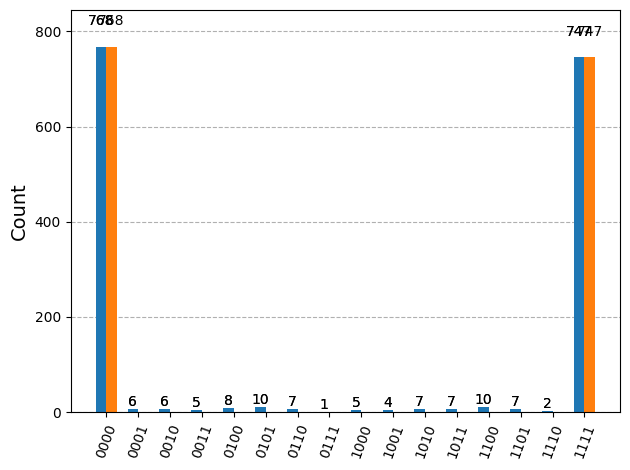

In [29]:

from qiskit_aer import QasmSimulator
from qiskit_aer import Aer

# Simulate and plot results
job_sim = QasmSim.run(qc.decompose(), shots=n_shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

filteredCount = {};
for key, value in counts.items():

  if key == '0000':

    filteredCount[key] = value;

  elif key == '1111':
    filteredCount[key] = value;

  else:
    filteredCount[key] = 0;


pCorrectAns = (filteredCount['0000'] + filteredCount['1111'])/ n_shots; # probability of getting the right state output

print("Probability of Correct Answer : {P}\n\n".format(P = pCorrectAns))
plot_histogram([counts, filteredCount])


# Implementing the Oracle and Diffuser with IBM Brisbane

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-15 20:35:43,989: Default instance not set. Searching all available instances.




Probability of Correct Answer : 0.119375




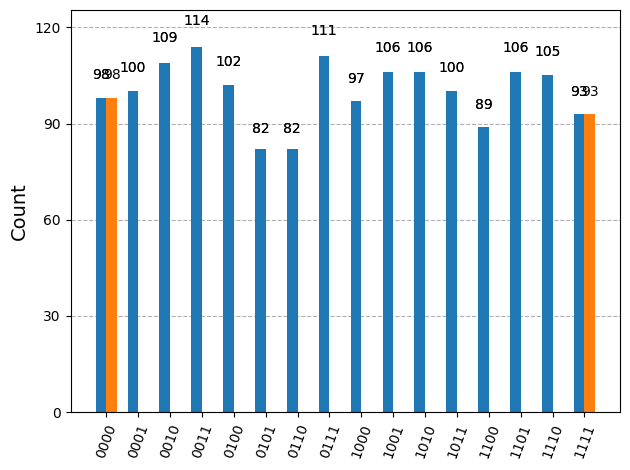

In [39]:


counts = backend_real(qc = qc, backend = None, shots = n_shots)

filteredCount = {};
for key, value in counts.items():

  if key == '0000':

    filteredCount[key] = value;

  elif key == '1111':
    filteredCount[key] = value;

  else:
    filteredCount[key] = 0;

pCorrectAns = (filteredCount['0000'] + filteredCount['1111']) / n_shots; # probability of getting the right state output

print("\n\nProbability of Correct Answer : {P}\n\n".format(P = pCorrectAns))

plot_histogram([counts, filteredCount])
